In [1]:
#!/usr/bin/env python3
"""
Compare Autoencoder (AE) baselines with Spherical-Harmonics (SH) reconstructions
using (radial   | foreground-phase-9ch | 3×background) latents per trajectory.
"""

# ------------------------------------------------------------------
# IMPORTS
# ------------------------------------------------------------------
import os, json, warnings, traceback
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
NSIDE             = 16          # HEALPix resolution
N_TOTAL_CLASSES   = 4           # background + 3 foreground
BACKGROUND_THRESH = 0.5         # > → pixel is background

PHASE_MAP_SPECS = {             # FG slice + BG-channel index
    "map1": {"fg_slice": slice(0, 3), "bg_idx": 0, "title": "Unsaturated focus"},
    "map2": {"fg_slice": slice(3, 6), "bg_idx": 1, "title": "Saturated focus"},
    "map3": {"fg_slice": slice(6, 9), "bg_idx": 2, "title": "Cholesterol focus"},
}

AE_METRICS_JSON = {
    "radial_mae": 0.5556,
    "phase_dim": 1152,
    "radial_dim": 384,
    "iou": [0.500, 0.319, 0.258, 0.307],   # NoLipid + clusters 0-2
    "acc": [0.620, 0.535, 0.386, 0.550],
    "wf1": [0.666, 0.483, 0.410, 0.469],
}

# ------------------------------------------------------------------
# GET FOLDER LIST
# ------------------------------------------------------------------
try:
    with open("training_output/outer_test_folders.txt") as f:
        folders_to_process = [ln.strip() for ln in f if ln.strip()]
except FileNotFoundError:
    folders_to_process = []

dummy_folders = ["configf_4092", "configf_4095"]
if not folders_to_process:
    folders_to_process = dummy_folders
print(f"[INFO] Processing {len(folders_to_process)} folder(s): {folders_to_process}")

# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def fill_and_shift(cluster_map: np.ndarray) -> np.ndarray:
    """Put NaNs →0 and shift labels +1 (background stays 0)."""
    out = np.empty_like(cluster_map, dtype=np.float32)
    nan_mask = np.isnan(cluster_map)
    out[nan_mask]  = 0.0
    out[~nan_mask] = cluster_map[~nan_mask] + 1.0
    return out

def sh_dim(lmax: int) -> int:
    #return hp.Alm.getsize(lmax)
    value = (lmax + 1) ** 2
    return value

def mae(a: np.ndarray, b: np.ndarray) -> float:
    return np.mean(np.abs(a - b))

def iou_from_cm(cm: np.ndarray) -> np.ndarray:
    tp = np.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    denom = tp + fp + fn
    return np.where(denom == 0, 0.0, tp / denom)

def f1_from_cm(cm: np.ndarray) -> np.ndarray:
    tp = np.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec = np.where(tp+fp == 0, 0.0, tp/(tp+fp))
    rec  = np.where(tp+fn == 0, 0.0, tp/(tp+fn))
    return np.where(prec+rec == 0, 0.0, 2*prec*rec/(prec+rec))

def acc_from_cm(cm: np.ndarray) -> np.ndarray:
    denom = cm.sum(1)
    return np.where(denom == 0, 0.0, np.diag(cm)/denom)

"""
def find_latent(folder: str, prefix: str) -> str | None:
    for fn in os.listdir(folder):
        if fn.startswith(prefix) and fn.endswith(".npy"):
            return os.path.join('../',folder, fn)
    return None
"""

def find_latent(folder: str, prefix: str) -> str | None:
    target_folder = os.path.join("..", folder)
    for fn in os.listdir(target_folder):
        if fn.startswith(prefix) and fn.endswith(".npy"):
            return os.path.join(target_folder, fn)
    return None

    

# ------------------------------------------------------------------
# ACCUMULATORS
# ------------------------------------------------------------------
agg = {
    "rad_mae": [],
    "rad_dim": [],
    "phase_dim_total": [],
}
for k in PHASE_MAP_SPECS:
    agg[k] = {"cm": []}

# ------------------------------------------------------------------
# MAIN LOOP
# ------------------------------------------------------------------
i = 1
for folder in folders_to_process:
    print(i)
    i = i + 1
    try:
        # ---------- locate latent files ------------------------
        rad_path = find_latent(folder, "outer_sh_radial_latent.npy")
        fg_path  = find_latent(folder, "outer_sh_phase_latent_fg_lmax22")
        bg_path  = find_latent(folder, "outer_sh_phase_latent_bg_lmax44")
        #print(rad_path)
        #print(fg_path)
        #print(bg_path)

        if not (os.path.exists(rad_path) and fg_path and bg_path):
            warnings.warn(f"[WARN] Missing latent(s) in {folder}; skipping.")
            continue

        sh_rad = np.load(rad_path)     # (frames, coeffs_rad, 1)
        sh_fg  = np.load(fg_path)      # (frames, coeffs_fg , 9)
        sh_bg  = np.load(bg_path)      # (frames, coeffs_bg , 3)

        n_frames = sh_rad.shape[0]
        if not (sh_fg.shape[0] == sh_bg.shape[0] == n_frames):
            warnings.warn(f"[WARN] Frame mismatch in {folder}; skipping.")
            continue

        lmax_rad = hp.Alm.getlmax(sh_rad.shape[1])
        lmax_fg  = hp.Alm.getlmax(sh_fg.shape[1])
        lmax_bg  = hp.Alm.getlmax(sh_bg.shape[1])

        # Dimensionality bookkeeping
        dim_fg = sh_dim(lmax_fg)
        dim_bg = sh_dim(lmax_bg)
        agg["rad_dim"].append(sh_dim(lmax_rad))
        agg["phase_dim_total"].append(3 * dim_bg + 9 * dim_fg)

        # ---------- load ground-truth --------------------------
        A = os.path.join('../',folder, "analysis_output")
        true_rad = np.load(os.path.join(A, "area_outer_radial_dist.npy"))
        true_maps = {
            "map1": fill_and_shift(np.load(os.path.join(
                    A, "nmfk_phase_map_OUTER_UNS_vs_SAT.npy"))),
            "map2": fill_and_shift(np.load(os.path.join(
                    A, "nmfk_phase_map_OUTER_SAT_vs_CHOL.npy"))),
            "map3": fill_and_shift(np.load(os.path.join(
                    A, "nmfk_phase_map_OUTER_CHOL_vs_UNS.npy"))),
        }
        if true_rad.shape[0] != n_frames:
            warnings.warn(f"[WARN] GT mismatch in {folder}; skipping.")
            continue

        # ---------- per-frame evaluation -----------------------
        for f in range(n_frames):
            # --- radial MAE
            alm_r = np.ascontiguousarray(sh_rad[f, :, 0])
            rad_recon = hp.alm2map(alm_r, NSIDE, lmax=lmax_rad)
            agg["rad_mae"].append(mae(true_rad[f], rad_recon))

            # --- background maps (3 channels) decoded once
            bg_recon_arr = np.stack([
                hp.alm2map(np.ascontiguousarray(sh_bg[f, :, c]),
                           NSIDE, lmax=lmax_bg)
                for c in range(3)             # channel order 0,1,2
            ], axis=-1)                       # (npix, 3)

            # --- foreground logits (9 channels) decoded once
            fg_recon_arr = np.stack([
                hp.alm2map(np.ascontiguousarray(sh_fg[f, :, c]),
                           NSIDE, lmax=lmax_fg)
                for c in range(9)
            ], axis=-1)                       # (npix, 9)

            # --- evaluate each phase map -----------------------
            for key, spec in PHASE_MAP_SPECS.items():
                gt = true_maps[key][f]
                logits = fg_recon_arr[:, spec["fg_slice"]]
                bg_mask = bg_recon_arr[:, spec["bg_idx"]] > BACKGROUND_THRESH

                pred_labels = logits.argmax(1) + 1
                pred_labels[bg_mask] = 0

                cm = confusion_matrix(gt.astype(int), pred_labels.astype(int),
                                       labels=list(range(N_TOTAL_CLASSES)))
                agg[key]["cm"].append(cm)

    except Exception as exc:
        warnings.warn(f"[ERROR] {folder}: {exc}")
        traceback.print_exc()

# ------------------------------------------------------------------
# REDUCE → SH metric summary
# ------------------------------------------------------------------
sh_metrics = {
    "rad_mae":         float(np.mean(agg["rad_mae"]))         if agg["rad_mae"] else np.nan,
    "rad_dim":         float(np.mean(agg["rad_dim"]))         if agg["rad_dim"] else np.nan,
    "phase_dim_total": float(np.mean(agg["phase_dim_total"])) if agg["phase_dim_total"] else np.nan,
}
for key in PHASE_MAP_SPECS:
    if agg[key]["cm"]:
        cm_sum = sum(agg[key]["cm"])
        sh_metrics[key] = {
            "iou": float(iou_from_cm(cm_sum)[1]),  # class=1 foreground
            "f1" : float(f1_from_cm(cm_sum)[1]),
            "acc": float(acc_from_cm(cm_sum)[1]),
        }
    else:
        sh_metrics[key] = {"iou": np.nan, "f1": np.nan, "acc": np.nan}

# ------------------------------------------------------------------
# PRINT
# ------------------------------------------------------------------
print("\n=== Autoencoder baselines ===")
print(json.dumps(AE_METRICS_JSON, indent=2))
print("\n=== Spherical Harmonics metrics (all folders, all frames) ===")
print(json.dumps(sh_metrics, indent=2))

[INFO] Processing 129 folder(s): ['configf_2989', 'configf_577', 'configf_3568', 'configf_2808', 'configf_322', 'configf_238', 'configf_2814', 'configf_430', 'configf_4095', 'configf_3906', 'configf_1775', 'configf_538', 'configf_698', 'configf_1731', 'configf_3308', 'configf_1628', 'configf_1816', 'configf_3265', 'configf_2883', 'configf_1046', 'configf_871', 'configf_524', 'configf_553', 'configf_3800', 'configf_2364', 'configf_2859', 'configf_3850', 'configf_1887', 'configf_2322', 'configf_3275', 'configf_3994', 'configf_3948', 'configf_1346', 'configf_660', 'configf_158', 'configf_3826', 'configf_2905', 'configf_2852', 'configf_3831', 'configf_3696', 'configf_1978', 'configf_3130', 'configf_3077', 'configf_2147', 'configf_3512', 'configf_2967', 'configf_3442', 'configf_1257', 'configf_3227', 'configf_3723', 'configf_3525', 'configf_45', 'configf_1016', 'configf_2945', 'configf_4087', 'configf_1967', 'configf_2298', 'configf_2836', 'configf_3655', 'configf_3619', 'configf_1331', 'co

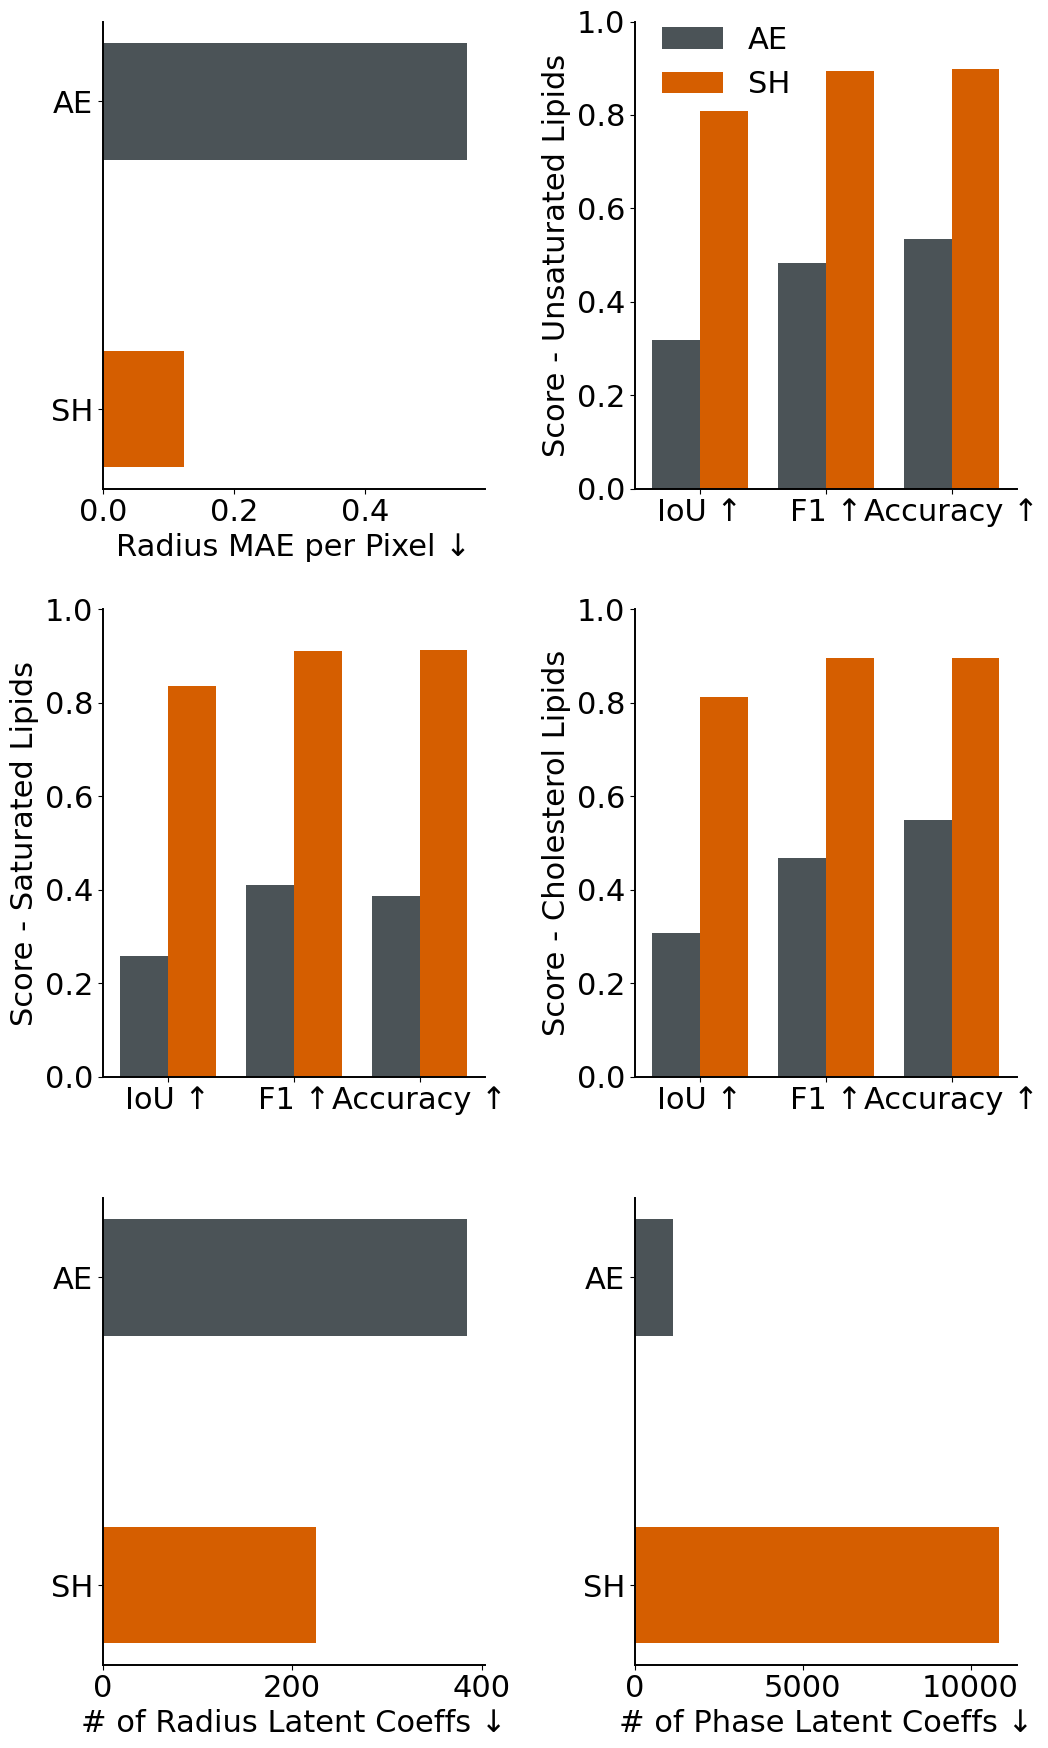

In [7]:
# ────────────────────────────────────────────────────────────────
#  Publication-quality plots  –  NO subplot titles
# ────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# axis-label text you might want to edit later
# ---------------------------------------------------------------
PANEL_LABELS = {
    "vesicle"   : "Radius MAE per Pixel ↓",
    "unsat"     : "Score - Unsaturated Lipids",
    "sat"       : "Score - Saturated Lipids",
    "chol"      : "Score - Cholesterol Lipids",
    "dim_rad"   : "# of Radius Latent Coeffs ↓",
    "dim_phase" : "# of Phase Latent Coeffs ↓",
}

PHASE_PANEL_MAP = {           # order: key → friendly-label
    "map1": ("unsat", PANEL_LABELS["unsat"]),
    "map2": ("sat",   PANEL_LABELS["sat"]),
    "map3": ("chol",  PANEL_LABELS["chol"]),
}

# ---------------------------------------------------------------
plt.rcParams.update({
    "font.family"     : "sans-serif",
    "font.size"       : 24,
    "axes.labelsize"  : 22,
    "xtick.labelsize" : 22,
    "ytick.labelsize" : 22,
    "legend.fontsize" : 22,
    "axes.linewidth"  : 1.4,
    "lines.linewidth" : 3,
})

AE_CLR, SH_CLR = "#4B5357", "#D55E00"   # publication palette
bar_w          = 0.38
metric_labels  = ["IoU ↑", "F1 ↑", "Accuracy ↑"]

fig, axes = plt.subplots(3, 2, figsize=(11, 18))

# ── 1. Vesicle Shape panel (unchanged) ─────────────────────────
ax = axes[0, 0]
ax.barh(0, AE_METRICS_JSON["radial_mae"], bar_w, color=AE_CLR, label="AE")
ax.barh(1, sh_metrics["rad_mae"],        bar_w, color=SH_CLR, label="SH")
ax.set_yticks([0, 1]); ax.set_yticklabels(["AE", "SH"])
ax.set_xlabel(PANEL_LABELS["vesicle"])
ax.set_xlim(left=0)
ax.invert_yaxis()

# ── 2–4. Phase panels  (add labels only on Unsaturated) ───────
phase_axes = [(0, 1), (1, 0), (1, 1)]
for (key, spec), (r, c) in zip(PHASE_MAP_SPECS.items(), phase_axes):
    ax  = axes[r, c]
    lbl = PHASE_PANEL_MAP[key][1]
    ae_idx = {"map1": 1, "map2": 2, "map3": 3}[key]

    ae_vals = [AE_METRICS_JSON["iou"][ae_idx],
               AE_METRICS_JSON["wf1"][ae_idx],
               AE_METRICS_JSON["acc"][ae_idx]]
    sh_vals = [sh_metrics[key]["iou"],
               sh_metrics[key]["f1"],
               sh_metrics[key]["acc"]]

    x = np.arange(len(metric_labels))

    # add labels only for Unsaturated (map1) so legend appears once
    label_AE = "AE" if key == "map1" else None
    label_SH = "SH" if key == "map1" else None

    ax.bar(x - bar_w/2, ae_vals, bar_w, color=AE_CLR, label=label_AE)
    ax.bar(x + bar_w/2, sh_vals, bar_w, color=SH_CLR, label=label_SH)
    ax.set_xticks(x); ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_ylabel(lbl)

# legend on Unsaturated panel (now it has handles)
axes[0, 1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 1.05))


# ── 5. Radial dimensionality panel (unchanged) ────────────────
ax = axes[2, 0]
ax.barh(0, AE_METRICS_JSON["radial_dim"], bar_w, color=AE_CLR)
ax.barh(1, sh_metrics["rad_dim"],        bar_w, color=SH_CLR)
ax.set_yticks([0, 1]); ax.set_yticklabels(["AE", "SH"])
ax.set_xlabel(PANEL_LABELS["dim_rad"])
ax.set_xlim(left=0)
ax.invert_yaxis()

# ── 6. Phase dimensionality panel (unchanged) ─────────────────
ax = axes[2, 1]
ax.barh(0, AE_METRICS_JSON["phase_dim"],        bar_w, color=AE_CLR)
ax.barh(1, sh_metrics["phase_dim_total"],       bar_w, color=SH_CLR)
ax.set_yticks([0, 1]); ax.set_yticklabels(["AE", "SH"])
ax.set_xlabel(PANEL_LABELS["dim_phase"])
ax.set_xlim(left=0)
ax.invert_yaxis()

# ── clean-up ──────────────────────────────────────────────────
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("ae_vs_sh_performance.png", dpi=600)
plt.savefig("ae_vs_sh_publication_quality_final.pdf", dpi=600)
plt.show()
